In [2]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [48]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
features_train_df = pd.read_csv('./features/features-train-all-v1.csv')
features_test_df = pd.read_csv('./features/features-test-all-v1.csv')

In [6]:
features_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27936 entries, 0 to 27935
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 34.7+ MB


In [7]:
emotions_number = 8

In [8]:
x_train = features_train_df.iloc[:, :-1].values
y_train = features_train_df['labels'].values

X_test = features_test_df.iloc[:, :-1].values
y_test = features_test_df['labels'].values

In [9]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y_train_enc = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test_enc = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [20]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [21]:
# splitting data
x_train, x_test, y_train, y_test = X_train, X_test, y_train, y_test

print(
    f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

train:	 ((27879, 162), (27879, 8))
test:	((3984, 162), (3984, 8))


In [10]:
# Split once to get the test and validation set
x_val, x_test, y_val_enc, y_test_enc = train_test_split(
    X_test, y_test_enc, test_size=0.3, random_state=42)
print(
    f'val:\t {x_val.shape, y_val_enc.shape,}\ntest:\t{x_test.shape, y_test_enc.shape}')

val:	 ((2793, 162), (2793, 8))
test:	((1198, 162), (1198, 8))


In [11]:
print(
    f'train:\t {x_train.shape, y_train_enc.shape,}')
print(
    f'val:\t {x_val.shape, y_val_enc.shape,}\ntest:\t{x_test.shape, y_test_enc.shape}')

train:	 ((27936, 162), (27936, 8))
val:	 ((2793, 162), (2793, 8))
test:	((1198, 162), (1198, 8))


## Model, train


nin


In [12]:
def nin_block(out_channels, kernel_size, strides, padding):
    return Sequential([
        Conv1D(out_channels, kernel_size, strides=strides,
               padding=padding),
        Conv1D(out_channels, 1, activation='relu'),
        Conv1D(out_channels, 1, activation='relu')
    ])

In [ ]:
# model = Sequential()

# model.add(Conv1D(96, kernel_size=7, padding='same',
#           activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(Conv1D(96, kernel_size=1, activation='relu'))
# model.add(Conv1D(96, kernel_size=1, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

# model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
# model.add(MaxPooling1D(pool_size=3, strides=2))

# model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
# model.add(MaxPooling1D(pool_size=3, strides=2))

# model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
# model.add(MaxPooling1D(pool_size=3, strides=2))

# model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
# model.add(MaxPooling1D(pool_size=3, strides=2))
# model.add(Dropout(0.3))

# model.add(nin_block(emotions_number, kernel_size=3, strides=1, padding='same'))
# model.add(GlobalAveragePooling1D())
# model.add(Flatten())

# model.compile(optimizer='adam', loss='categorical_crossentropy',
#               metrics=['accuracy'])


# model.summary()

In [70]:
# model = Sequential([
#     nin_block(96, kernel_size=11, strides=4, padding='valid'),
#     MaxPooling1D(pool_size=3, strides=2),
#     nin_block(256, kernel_size=5, strides=1, padding='same'),
#     MaxPooling1D(pool_size=3, strides=2),
#     nin_block(384, kernel_size=3, strides=1, padding='same'),
#     MaxPooling1D(pool_size=3, strides=2),
#     Dropout(0.5),
#     nin_block(emotions_number, kernel_size=3, strides=1, padding='same'),
#     GlobalAveragePooling1D(),
#     Flatten()
# ])

model = Sequential()

model.add(Conv1D(96, kernel_size=7, padding='same',
          activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(96, kernel_size=1, activation='relu'))
model.add(Conv1D(96, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(nin_block(256, kernel_size=5, strides=1, padding='same'))
model.add(MaxPooling1D(pool_size=3, strides=2))
model.add(Dropout(0.3))

model.add(nin_block(emotions_number, kernel_size=3, strides=1, padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_297 (Conv1D)         (None, 162, 96)           768       
                                                                 
 conv1d_298 (Conv1D)         (None, 162, 96)           9312      
                                                                 
 conv1d_299 (Conv1D)         (None, 162, 96)           9312      
                                                                 
 max_pooling1d_85 (MaxPoolin  (None, 81, 96)           0         
 g1D)                                                            
                                                                 
 sequential_100 (Sequential)  (None, 81, 256)          254720    
                                                                 
 max_pooling1d_86 (MaxPoolin  (None, 40, 256)          0         
 g1D)                                                

In [71]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.000001)

early_stop = EarlyStopping(monitor='loss', patience=5)


history = model.fit(x_train, y_train_enc, batch_size=32, epochs=100,
                    validation_data=(x_val, y_val_enc), callbacks=[rlrp, early_stop])

Epoch 1/100
873/873 [==============================] - 22s 24ms/step - loss: 4.0285 - accuracy: 0.2341 - val_loss: 3.9514 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 2/100
873/873 [==============================] - 20s 23ms/step - loss: 3.9269 - accuracy: 0.2753 - val_loss: 3.8821 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 3/100
873/873 [==============================] - 20s 23ms/step - loss: 3.8936 - accuracy: 0.2879 - val_loss: 3.7964 - val_accuracy: 0.3222 - lr: 0.0010
Epoch 4/100
873/873 [==============================] - 20s 23ms/step - loss: 3.8303 - accuracy: 0.3144 - val_loss: 3.7411 - val_accuracy: 0.3466 - lr: 0.0010
Epoch 5/100
873/873 [==============================] - 20s 23ms/step - loss: 3.9289 - accuracy: 0.2944 - val_loss: 3.8060 - val_accuracy: 0.3212 - lr: 0.0010
Epoch 6/100
873/873 [==============================] - 21s 24ms/step - loss: 3.8903 - accuracy: 0.3010 - val_loss: 3.8222 - val_accuracy: 0.3183 - lr: 0.0010
Epoch 7/100
873/873 [==============================]

KeyboardInterrupt: 

In [33]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

In [34]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

38/38 [==============================] - 1s 15ms/step - loss: 1.4868 - accuracy: 0.4098
Accuracy of our model on test data :  40.984976291656494 %


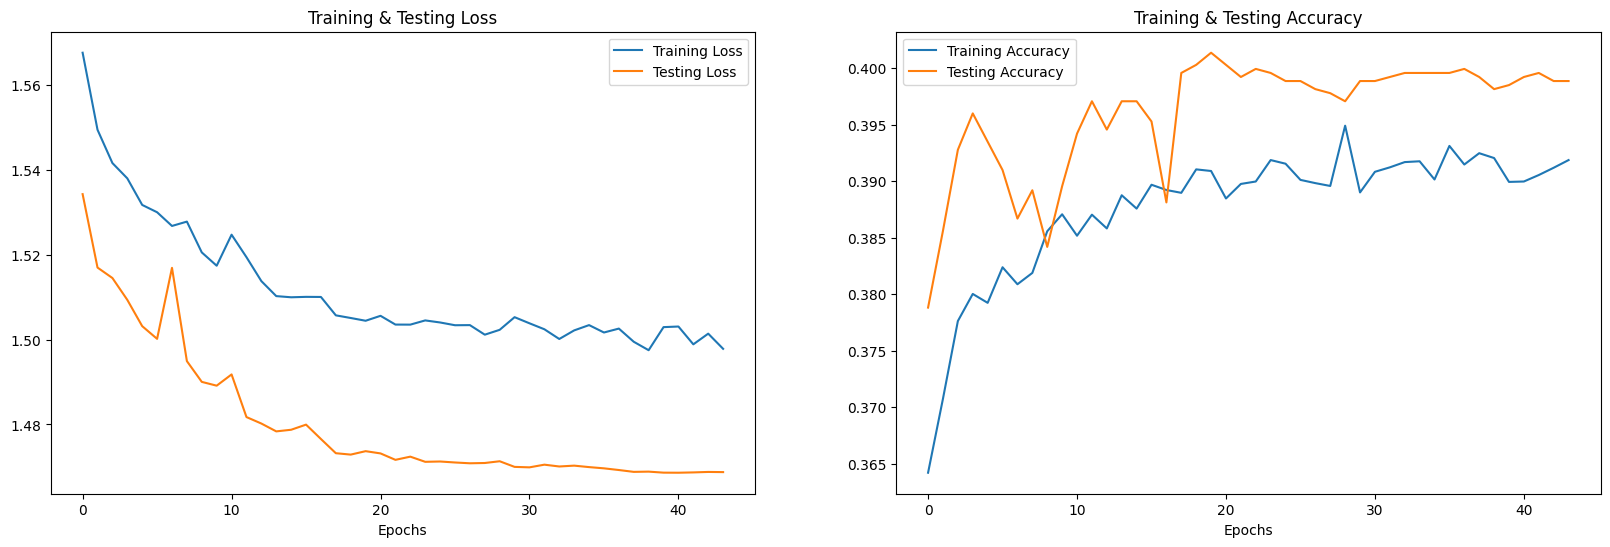

In [57]:
print_report(model, history, x_test, y_test_enc)

In [58]:
# predicting on test data.
pred_enc = model.predict(x_test)
pred = encoder.inverse_transform(pred_enc)

y_test_decoded = encoder.inverse_transform(y_test_enc)

38/38 [==============================] - 1s 8ms/step


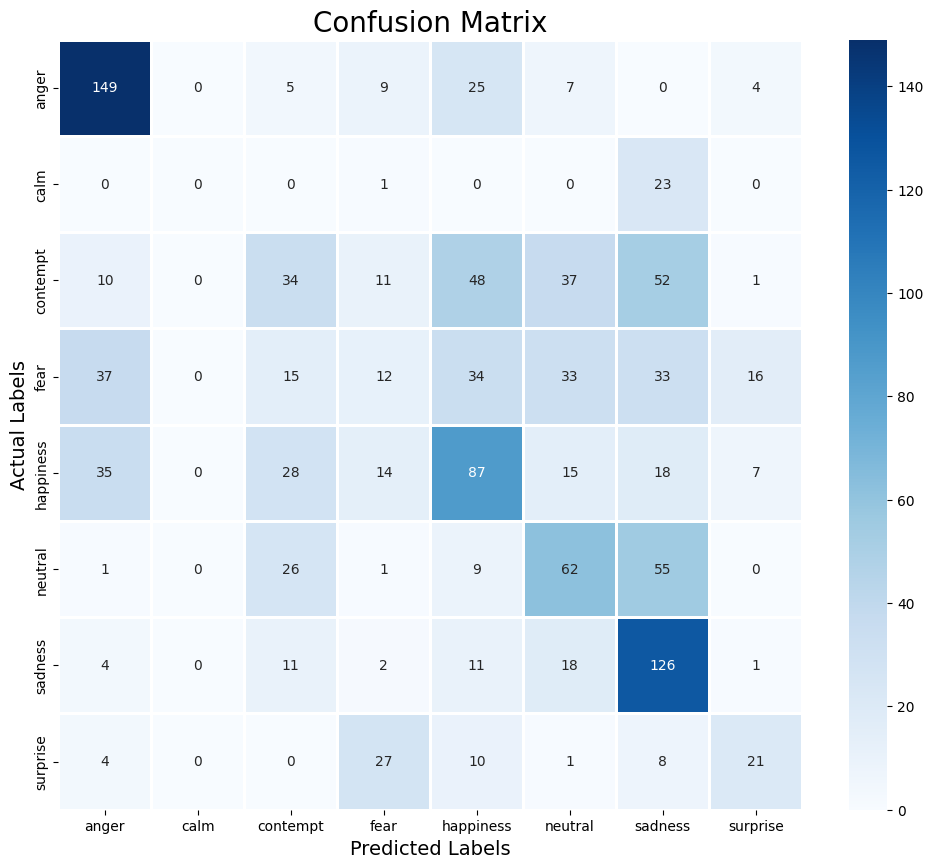

In [59]:
print_confusion_matrix(y_test_decoded, pred)

In [60]:
print(classification_report(y_test_decoded, pred))

              precision    recall  f1-score   support

       anger       0.62      0.75      0.68       199
        calm       0.00      0.00      0.00        24
    contempt       0.29      0.18      0.22       193
        fear       0.16      0.07      0.09       180
   happiness       0.39      0.43      0.41       204
     neutral       0.36      0.40      0.38       154
     sadness       0.40      0.73      0.52       173
    surprise       0.42      0.30      0.35        71

    accuracy                           0.41      1198
   macro avg       0.33      0.36      0.33      1198
weighted avg       0.37      0.41      0.38      1198



## Save model


In [39]:
model.save('./saved_models/nin4-v2.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('./saved_models/nin4-v2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpglsaa5eg\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpglsaa5eg\assets


metadata (skip for now)


In [22]:
# from tflite_support import flatbuffers
# from tflite_support import metadata as _metadata
# from tflite_support import metadata_schema_py_generated as _metadata_fb

# # Creates model info.
# model_meta = _metadata_fb.ModelMetadataT()
# model_meta.name = "Speech emotion recognition"
# model_meta.description = ("Identify emotion of human voice")
# model_meta.version = "v2"
# model_meta.author = "Mykola Nosenko"
# model_meta.license = ("Apache License. Version 2.0 "
#                       "http://www.apache.org/licenses/LICENSE-2.0.")  # verify later

In [23]:
# # Creates output info.
# output_meta = _metadata_fb.TensorMetadataT()
# output_meta.name = "probability"
# output_meta.description = "Probabilities of the 8 labels respectively."
# output_meta.content = _metadata_fb.ContentT()
# output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
# output_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.FeatureProperties)
# output_stats = _metadata_fb.StatsT()
# output_stats.max = [1.0]
# output_stats.min = [0.0]
# output_meta.stats = output_stats
# label_file = _metadata_fb.AssociatedFileT()
# label_file.name = os.path.basename("./emotion_labels.txt")
# label_file.description = "Labels for emotions that the model can recognize."
# label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
# output_meta.associatedFiles = [label_file]

In [24]:
# # Creates subgraph info.
# subgraph = _metadata_fb.SubGraphMetadataT()
# # subgraph.inputTensorMetadata = [input_meta]
# subgraph.outputTensorMetadata = [output_meta]
# model_meta.subgraphMetadata = [subgraph]

# b = flatbuffers.Builder(0)
# b.Finish(
#     model_meta.Pack(b),
#     _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
# metadata_buf = b.Output()

In [25]:
# populator = _metadata.MetadataPopulator.with_model_file('./model.tflite')
# populator.load_metadata_buffer(metadata_buf)
# populator.load_associated_files(["./emotion_labels.txt"])
# populator.populate()

In [26]:
# displayer = _metadata.MetadataDisplayer.with_model_file(
#     "./model.tflite")
# export_json_file = os.path.join("D:/Documents/export_models/model.json")
# json_file = displayer.get_metadata_json()
# # Optional: write out the metadata as a json file
# with open(export_json_file, "w") as f:
#     f.write(json_file)

In [27]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(
#     "./saved_models/ser4.keras")  # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('ser4-model.tflite', 'wb') as f:
#     f.write(tflite_model)

## Test model


In [28]:
# model_l = tf.keras.models.load_model('./saved_models/ser4-v4.keras')
# model_l.summary()

In [32]:
X_uk = features_uk_df.iloc[:, :-1].values
y_uk = features_uk_df['labels'].values

In [33]:
fear_label = 'fear'
contempt_label = 'contempt'  # disgust
happiness_label = 'happiness'
anger_label = 'anger'
sadness_label = 'sadness'
neutral_label = 'neutral'
surprise_label = 'surprise'
calm_label = 'calm'

emotions = [fear_label, contempt_label, happiness_label, anger_label,
            sadness_label, neutral_label, surprise_label, calm_label]

In [34]:
encoder_uk = OneHotEncoder(categories=[emotions])
y_uk = encoder_uk.fit_transform(np.array(y_uk).reshape(-1, 1)).toarray()

In [35]:
loss, acc = model.evaluate(X_uk, y_uk, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 1s - loss: 17.2547 - accuracy: 0.1538 - 823ms/epoch - 823ms/step
Restored model, accuracy: 15.38%


In [36]:
pred_uk = model.predict(X_uk)
pred_uk_decoded = encoder_uk.inverse_transform(pred_uk)
y_uk_decoded = encoder_uk.inverse_transform(y_uk)
print(pred_uk_decoded.shape)
print(y_uk_decoded.shape)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step
(26, 1)
(26, 1)


In [37]:
cm = confusion_matrix(y_uk_decoded, pred_uk_decoded)
cm

array([[0, 0, 0, 2, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 3, 0, 0, 3, 1, 4],
       [0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 3, 1, 4],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [38]:
print(classification_report(y_uk_decoded, pred_uk_decoded))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         3
        calm       0.00      0.00      0.00         0
    contempt       0.00      0.00      0.00        12
        fear       0.33      0.50      0.40         2
   happiness       0.50      0.38      0.43         8
     sadness       0.00      0.00      0.00         1
    surprise       0.00      0.00      0.00         0

    accuracy                           0.15        26
   macro avg       0.12      0.12      0.12        26
weighted avg       0.18      0.15      0.16        26



In [80]:
from model_analyzer import get_model_memory_usage


print(f'Memory usage: {get_model_memory_usage(32, model)} GB')

Memory usage: 0.015 GB
